#ADVERSARIAL EXAMPLE GENERATION

In this notebook we will implement some famous adversarial attacks including FGSM and ... . <br/>
Our main focus will be the original paper which was published by Goodfellow and his team. You can see the paper by <a href="https://arxiv.org/pdf/1412.6572.pdf">this link</a>.
The attacks will be implemented in this notebook are :


*   FGSM



I will use The Cat or Dog classification problem as the main task.
I have a pre-trained VGG model for this task and We just have to download the dataset.

So for the first step, lets download the dataset and prepare it. <br/>
The dataset is from the <a href="www.kaggle.com">Kaggle</a> website.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! mkdir training_dataset
! mkdir test_dataset

!kaggle datasets download -d biaiscience/dogs-vs-cats

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 99% 811M/817M [00:16<00:00, 29.6MB/s]
100% 817M/817M [00:17<00:00, 50.1MB/s]


In [ ]:
import zipfile
import os

with zipfile.ZipFile("dogs-vs-cats.zip", 'r') as zip_ref:
    zip_ref.extractall(".")
counter = 0
src_name = './train/train/'
for f in os.listdir(src_name):
    os.rename(f'{src_name}{f}', f'./training_dataset/{f}')
    counter += 1

train_counter = counter
counter = 0

src_name = './test/test/'
for f in os.listdir(src_name):
    os.rename(f'{src_name}{f}', f'./test_dataset/{f}')
    counter += 1

print(f'training images : {train_counter} , test images : {counter}')

training images : f25000 , test images : f12500


In [ ]:
! rm -rf test train dogs-vs-cats.zip

In [ ]:
! mkdir ./training_dataset/dogs
! mkdir ./training_dataset/cats
ndogs = ncats = 0
for f in os.listdir('./training_dataset'):
    if 'dog' in f and f != 'dogs':
        os.rename(f'./training_dataset/{f}', f'./training_dataset/dogs/{f}')
        ndogs += 1
    elif 'cat' in f and f != 'cats':
        os.rename(f'./training_dataset/{f}', f'./training_dataset/cats/{f}')
        ncats += 1
print('successfully created')
print(f'#cats: {ncats} , #dogs: {ndogs}')

successfully created
#cats: 12500 , #dogs: 12500


Now It seems that the folders are ready and the only thing is left, is to import the libraries and create the dataset object and then the dataset is ready to use.

In [ ]:
from datetime import datetime
from random import randrange
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.utils as vutils
import torchvision.transforms as transforms

device = torch.device('cuda:0')
print('setup complete')

setup complete


In [ ]:
def load_dataset(data_path):
    transformations = torchvision.transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformations,
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=1,
        shuffle=True
    )

    return train_loader

In [ ]:
dogs = cats = 0
dataset_fname = './training_dataset'
for f in os.listdir('./extras'):
    if 'cat' in f:
        if cats < 2500:
            os.rename(f'./extras/{f}', f'{dataset_fname}/cats/{f}')
            cats += 1
    elif 'dog' in f:
        if dogs < 2500:
            os.rename(f'./extras/{f}', f'{dataset_fname}/dogs/{f}')
            dogs += 1

cats = len(os.listdir(f'{dataset_fname}/cats'))
dogs = len(os.listdir(f'{dataset_fname}/dogs'))
print(f'We have {dogs} dogs  and  {cats} cats.')

We have 5000 dogs  and  5000 cats.


Now lets see some images of this dataset.

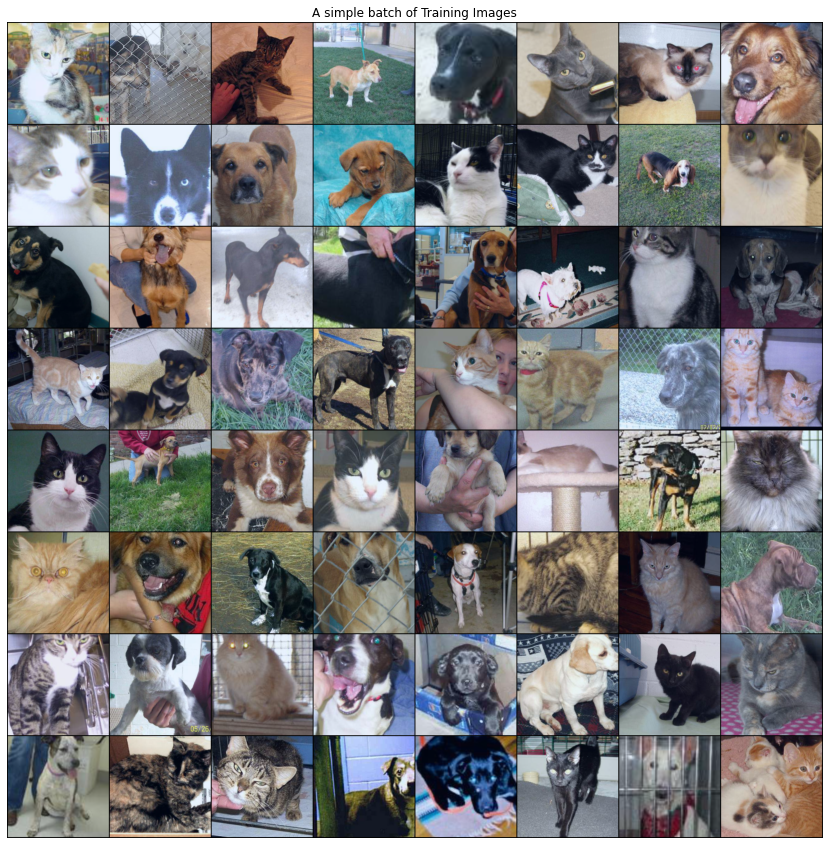

In [ ]:
training_dataset = load_dataset('./training_dataset')

abatch = next(iter(training_dataset))

plt.figure(figsize=(15, 15))
plt.axis("off")
plt.title("A simple batch of Training Images")
plt.imshow(np.transpose(vutils.make_grid(abatch[0], padding=2, normalize=True).cpu(),(1,2,0)))

So everything seem fine, Its time to go for the model!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
class VGGNet(nn.Module):

    def __init__(self, num_classes=2):
        super(VGGNet, self).__init__()
        self.features = self.make_layers()
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def make_layers(self, batch_norm=False):
        layers = []
        in_channels = 3
        cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

In [ ]:
model = VGGNet().to(device)
model.load_state_dict(torch.load('./drive/My Drive/models/model_vgg.dms')['model_state_dict'])
model.eval()

VGGNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

####FGSM Attack:
$$ \text{Attacked Image} = \text{Initial Image} + \mathbb{\epsilon} . \text {sign} [ \nabla_{\mathbf{x}} \mathbb{J}(\theta, x, y) ]$$

In [ ]:
epsilons = [0, .05, .15, .25, .3]

def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + (epsilon*sign_data_grad)
    perturbed_image = torch.clamp(perturbed_image, 0, 255)
    return perturbed_image

In [ ]:
def perform_attack(model, dataset, epsilon):

    correct = 0
    adv_examples = []
    criterion = nn.CrossEntropyLoss()

    for i, (data, target) in enumerate(dataset):

        if (i + 1) % 2000 == 0:
            print(f'Processing : {i + 1} / {len(dataset)}')

        data, target = data.to(device), target.to(device)

        data.requires_grad = True # Because the gradient was respect to the input

        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        if init_pred.item() != target.item(): 
            # If the prediction was wrong, we wont do anything and just move on.
            continue

        loss = criterion(output, target)
        model.zero_grad()

        loss.backward()

        data_grad = data.grad.data

        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1]

        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(dataset))
    print("Epsilon: {}\tTest Accuracy = {}".format(epsilon, final_acc))
    print('##################################################\n')
    return final_acc, adv_examples

In [ ]:
def run_attacks():
    accuracies = []
    examples = []

    # Run test for each epsilon
    for eps in epsilons:
        acc, ex = perform_attack(model, training_dataset, eps)
        accuracies.append(acc)
        examples.append(ex)
    return accuracies, examples

In [ ]:
accuracies, examples = run_attacks()

Processing : 2000 / 10000
Processing : 4000 / 10000
Processing : 6000 / 10000
Processing : 8000 / 10000
Processing : 10000 / 10000
Epsilon: 0	Test Accuracy = 0.8858
##################################################

Processing : 2000 / 10000
Processing : 4000 / 10000
Processing : 6000 / 10000
Processing : 8000 / 10000
Processing : 10000 / 10000
Epsilon: 0.05	Test Accuracy = 0.3357
##################################################

Processing : 2000 / 10000
Processing : 4000 / 10000
Processing : 6000 / 10000
Processing : 8000 / 10000
Processing : 10000 / 10000
Epsilon: 0.15	Test Accuracy = 0.1353
##################################################

Processing : 2000 / 10000
Processing : 4000 / 10000
Processing : 6000 / 10000
Processing : 8000 / 10000
Processing : 10000 / 10000
Epsilon: 0.25	Test Accuracy = 0.12
##################################################

Processing : 2000 / 10000
Processing : 4000 / 10000
Processing : 6000 / 10000
Processing : 8000 / 10000
Processing : 10000 / 

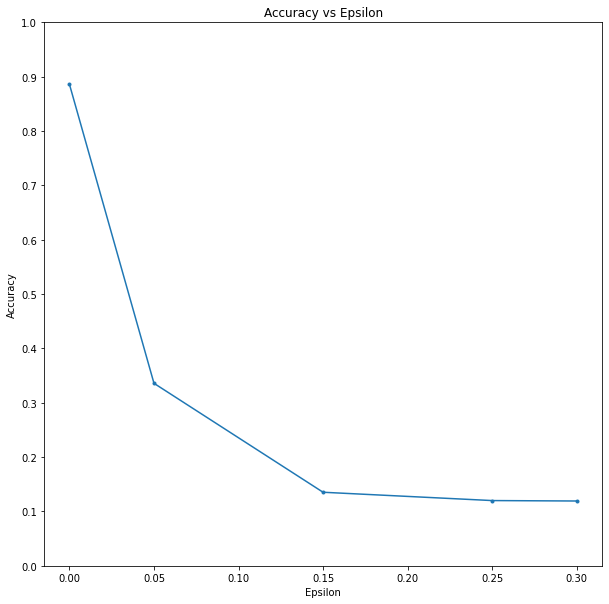

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(epsilons, accuracies, ".-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

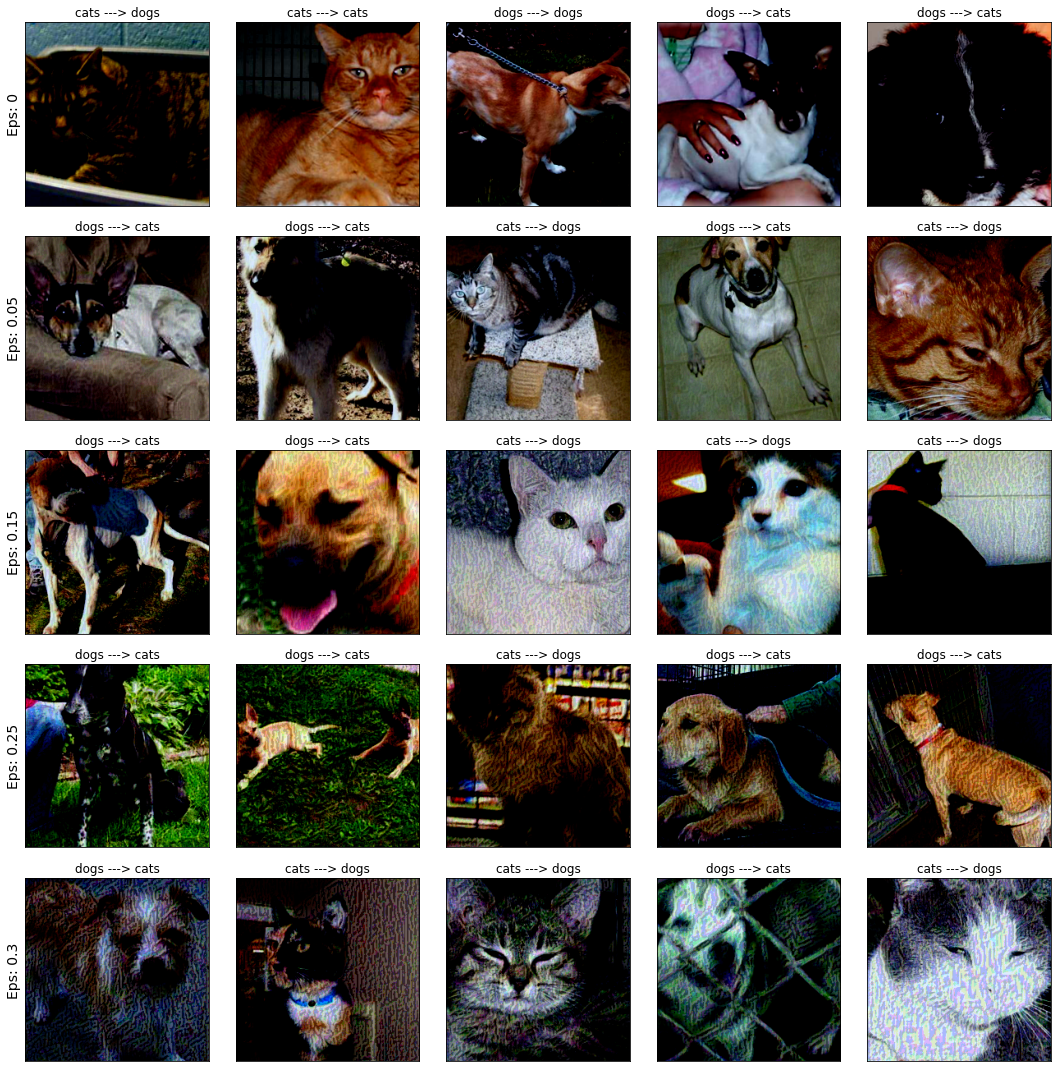

In [121]:
cnt = 0
plt.figure(figsize=(15,15))
names = training_dataset.dataset.classes
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig, adv, ex = examples[i][j]
        plt.title("{} ---> {}".format(names[orig], names[adv]))
        plt.imshow(np.transpose(vutils.make_grid(torch.Tensor(ex), padding=2, normalize=True).cpu(),(1,2,0)))
plt.tight_layout()
plt.show()